In [1]:
import pandas as pd
import numpy as np
import yaml
import pycountry
import pycountry_convert as pc
import matplotlib.pyplot as plt

In [2]:
data_swissre = pd.read_csv('data/swissre/swissre_features_final.csv', parse_dates=['date']).set_index('date')

/Users/giorgiomannarini/miniforge3/envs/pytorch_env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (69,70) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


- Cases: cumulative
- Deaths: cumulative
- New cases: daily
- New deaths: daily
- Recovered: difference (entered - exited)
- Stats on population divided per age: 52% null
- Fatality rate percentage: total deaths / total cases. Problem: should be shifted
- Days since outbreak can be used instead of a fixed 04-01 date (maybe one month after the first outbreak?)
- real_gdp_growth: 79% of null. Can't be used together with non-life and life premium growth.
- am_fear_factor_index ???
- Unemployment rate: many nulls but seems good. Also, 2021 is forecast.
- Gdp quarterly: same-> many nans but good indicator
- covid19_reopen_criteria_14_day_new_cases_downward_trajectory: ??? Can be seen as policy?
- Stage number: 9 levels for the stage of the pandemic. Hovering = null (maybe replace with 0)
- epiforecasts_effective_reproduction_number_median: median of the rep. number, it is right to report it. Taking also 90% CI and 50% CI
- Maybe look at projections

**TO ADD**: 
- Population density
- Median age
- Human development index
- Diabetes prevalence
- Life expectancy

Weather: to use or not to use? 
Policies: boolean or level? 


# Selecting columns for the first model

In [3]:
with open('config/swissre_features.yaml', 'r', encoding='utf-8') as file:
    swissre_features = yaml.load(file, Loader=yaml.FullLoader)

In [4]:
columns_to_use= swissre_features['main'] +\
            swissre_features['demography'] +\
            swissre_features['sanitary'] +\
            swissre_features['economic'] +\
            swissre_features['weather'] +\
            swissre_features['policies']['to_use'] +\
            swissre_features['outcomes']['to_use'] + ['cases']

outcome = 'epiforecasts_effective_reproduction_number_median' # r_estim epiforecasts_effective_reproduction_number_median

In [5]:
df = data_swissre[columns_to_use].copy()

In [6]:
# Taking the data starting from the 1st of april. ALTERNATIVE: use days since outbreak
df = df[df.index >= '2020-04-01'].sort_index()

In [7]:
# Filtering for valid countries: 
def filter_valid_countries(data, min_ratio):
    iso_codes = []
    for iso_code in data.iso_code.unique():
        data_country = data[data.iso_code == iso_code]['epiforecasts_effective_reproduction_number_median'].dropna()
        n_values = data_country.shape[0]

    # If rows exist for that country with a valid r_estim value
        if n_values > 0:
            n_days = (data_country.index[-1] - data_country.index[0]).days + 1
            #print(n_days)
            ratio = n_values / n_days

            if ratio > min_ratio:
                iso_codes.append(iso_code)
            
    return data[data['iso_code'].isin(iso_codes)]

df = filter_valid_countries(df, 0.9)

In [8]:
print(f"Number of countries: {len(df.iso_code.unique())}")

Number of countries: 170


In [9]:
# Putting NaN where the estimated reproduction number is larger than 4
df[outcome] = np.where(df[outcome] >= 4, np.nan, df[outcome])

In [10]:
# Shifting the reproduction rate by 11 days for each country
df['date_index'] = df.index
df = df.sort_values(by = ['iso_code', 'date_index'])

if outcome == 'r_estim':
    df['shifted_r_estim'] = df[outcome].shift(-11).where(df['iso_code'].eq(df['iso_code'].shift(-11)))
else:
    # Already shifted by default
    df['shifted_r_estim'] = df[outcome]
    

In [11]:
# retaining only the countries that exceeded 2000 casese
iso_codes = list(df[df['cases'] > 2000]['iso_code'].unique())
df = df[df['iso_code'].isin(iso_codes)]
print(f"Number of countries: {len(df.iso_code.unique())}")

Number of countries: 161


**NOTE**: We are not dropping NaN values (we have to check what happens)

# Training the first model

In [12]:
from classes.context import Context
from classes.pipeline import Pipeline
from classes.plot import Plot

In [33]:
final_iso_code = 'CHE'

# Final training colums
train_cols= swissre_features['demography'] +\
            swissre_features['sanitary'] +\
            swissre_features['economic'] +\
            swissre_features['weather'] +\
            swissre_features['policies']['to_use']

final_train_cols = [col for col in train_cols if not df[df['iso_code'] == final_iso_code][col].isnull().all()]

In [34]:
list(set(train_cols) - set(final_train_cols))

[]

In [35]:
context = Context()

Global seed set to 42


In [36]:
pipeline = Pipeline(df, final_train_cols, 'shifted_r_estim', final_iso_code, context)
pipeline.fit_pipeline(save_model=False)

Global seed set to 42


Training the model...



Global seed set to 42
GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name     | Type   | Params
------------------------------------
0 | lstm_1   | LSTM   | 3.9 K 
1 | linear_1 | Linear | 1.9 K 
2 | linear_2 | ReLU   | 0     
3 | mixed_1  | Linear | 1.1 K 
4 | mixed_2  | ReLU   | 0     
5 | mixed_3  | Linear | 16    
6 | mixed_4  | ReLU   | 0     
------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) 

.................................

In [37]:
predictions = pipeline.predict()

plot = Plot(df, 'shifted_r_estim', final_iso_code, save_path='./plots/')

The mean average error was 0.02273316295942206


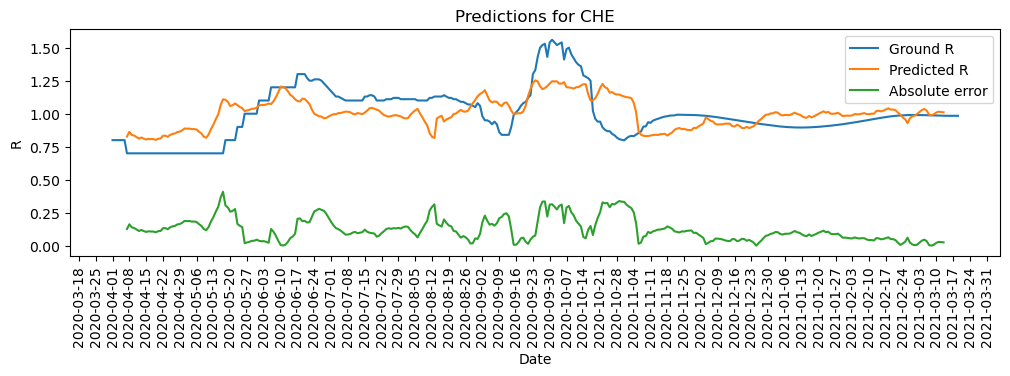

In [38]:
plot.plot_results(predictions, show = True)

In [37]:
# Building the dataset
test_indices = df['iso_code'] == final_iso_code
index = df.loc[test_indices].index
ground = df.loc[test_indices][outcome]
error_curve = np.abs(ground - predictions)

## Model for many countries with final dataframe

In [39]:
iso_codes = ['AFG', 'AGO', 'ALB', 'AND', 'ARE', 'ARG', 'ARM', 'AUS', 
             'AUT', 'AZE', 'BEL', 'BEN', 'BFA', 'BGD', 'BGR', 'BHR', 'BHS', 
             'BIH', 'BLR', 'BOL', 'BRA', 'BWA', 'CAF', 'CAN', 'CHE', 'CHL', 
             'CHN', 'CIV', 'CMR', 'COD', 'COG', 'COL', 'COM', 'CPV', 'CRI', 
             'CUB', 'CYP', 'CZE', 'DEU', 'DJI', 'DNK', 'DOM', 'DZA', 'ECU', 
             'EGY', 'ESP', 'EST', 'ETH', 'FIN', 'FRA', 'GAB', 'GBR', 'GEO', 
             'GHA', 'GIN', 'GMB', 'GNB', 'GRC', 'GTM', 'GUY', 'HND', 'HRV', 
             'HTI', 'HUN', 'IDN', 'IND', 'IRL', 'IRN', 'IRQ', 'ISL', 'ISR', 
             'ITA', 'JAM', 'JOR', 'JPN', 'KAZ', 'KEN', 'KGZ', 'KOR', 'KWT', 
             'LBN', 'LBY', 'LKA', 'LSO', 'LTU', 'LUX', 'LVA', 'MAR', 'MDA', 
             'MDG', 'MDV', 'MEX', 'MKD', 'MLI', 'MLT', 'MMR', 'MOZ', 'MRT', 
             'MWI', 'MYS', 'NER', 'NGA', 'NIC', 'NLD', 'NOR', 'NPL', 'NZL', 
             'OMN', 'PAK', 'PAN', 'PER', 'PHL', 'POL', 'PRT', 'PRY', 'PSE', 
             'QAT', 'ROU', 'RUS', 'RWA', 'SAU', 'SDN', 'SEN', 'SGP', 'SLE', 
             'SLV', 'SOM', 'SRB', 'SSD', 'SVK', 'SVN', 'SWE', 'SWZ', 'SYR', 
             'TCD', 'TGO', 'THA', 'TJK', 'TUN', 'TUR', 'UGA', 'UKR', 'URY', 
             'USA', 'UZB', 'VEN', 'YEM', 'ZAF', 'ZMB', 'ZWE']

Global seed set to 42
Global seed set to 42


Training the model...



Global seed set to 42
GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name     | Type   | Params
------------------------------------
0 | lstm_1   | LSTM   | 3.9 K 
1 | linear_1 | Linear | 300   
2 | linear_2 | ReLU   | 0     
3 | mixed_1  | Linear | 1.1 K 
4 | mixed_2  | ReLU   | 0     
5 | mixed_3  | Linear | 16    
6 | mixed_4  | ReLU   | 0     
------------------------------------
5.3 K     Trainable params
0         Non-trainable params
5.3 K     Total params
0.021     Total estimated model params size (MB)
The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) 

...........................The mean average error was 0.03613472735666463


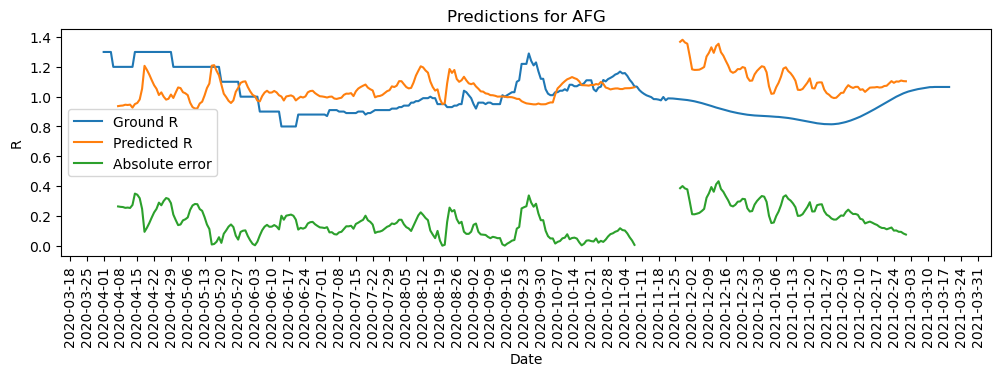

Global seed set to 42


Training the model...



Global seed set to 42
GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name     | Type   | Params
------------------------------------
0 | lstm_1   | LSTM   | 3.9 K 
1 | linear_1 | Linear | 300   
2 | linear_2 | ReLU   | 0     
3 | mixed_1  | Linear | 1.1 K 
4 | mixed_2  | ReLU   | 0     
5 | mixed_3  | Linear | 16    
6 | mixed_4  | ReLU   | 0     
------------------------------------
5.3 K     Trainable params
0         Non-trainable params
5.3 K     Total params
0.021     Total estimated model params size (MB)
The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) 

.....

Detected KeyboardInterrupt, attempting graceful shutdown...


The mean average error was 0.019450669640311


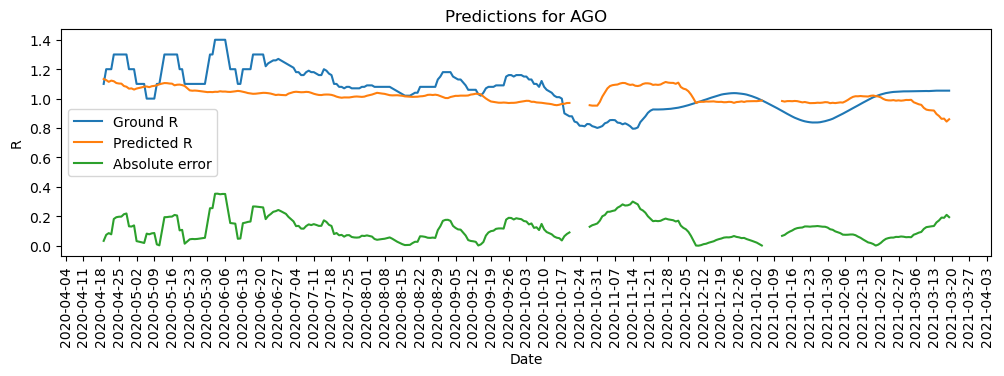

Global seed set to 42


Training the model...



Global seed set to 42
GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name     | Type   | Params
------------------------------------
0 | lstm_1   | LSTM   | 3.9 K 
1 | linear_1 | Linear | 700   
2 | linear_2 | ReLU   | 0     
3 | mixed_1  | Linear | 1.1 K 
4 | mixed_2  | ReLU   | 0     
5 | mixed_3  | Linear | 16    
6 | mixed_4  | ReLU   | 0     
------------------------------------
5.7 K     Trainable params
0         Non-trainable params
5.7 K     Total params
0.023     Total estimated model params size (MB)
The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) 

...........................The mean average error was 0.016175149601194313


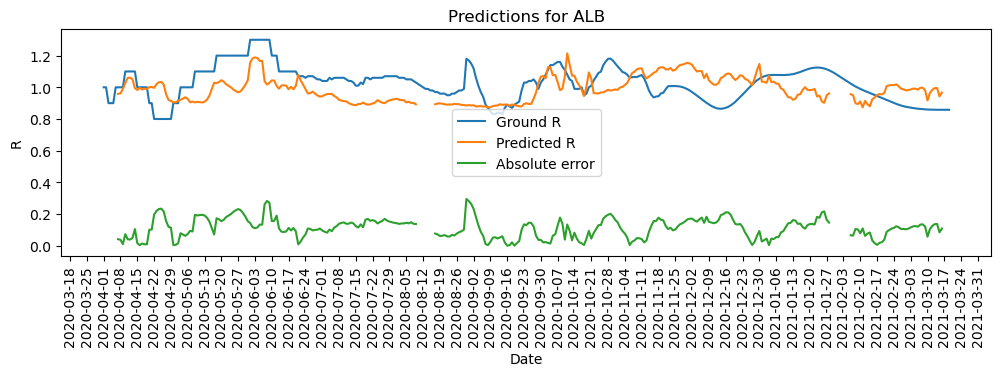

Global seed set to 42


Training the model...



Global seed set to 42
GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name     | Type   | Params
------------------------------------
0 | lstm_1   | LSTM   | 3.9 K 
1 | linear_1 | Linear | 300   
2 | linear_2 | ReLU   | 0     
3 | mixed_1  | Linear | 1.1 K 
4 | mixed_2  | ReLU   | 0     
5 | mixed_3  | Linear | 16    
6 | mixed_4  | ReLU   | 0     
------------------------------------
5.3 K     Trainable params
0         Non-trainable params
5.3 K     Total params
0.021     Total estimated model params size (MB)
The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) 

...

In [ ]:
context = Context()
for final_iso_code in iso_codes:
    final_train_cols = [col for col in train_cols if not df[df['iso_code'] == final_iso_code][col].isnull().all()]
    pipeline = Pipeline(df, final_train_cols, 'shifted_r_estim', final_iso_code, context)
    pipeline.fit_pipeline(save_model=False)
    
    predictions = pipeline.predict()
    plot = Plot(df, 'shifted_r_estim', final_iso_code, save_path='./plots/')
    plot.plot_results(predictions, show = True)

### Shap values section

invalid value encountered in true_divide
invalid value encountered in true_divide
Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


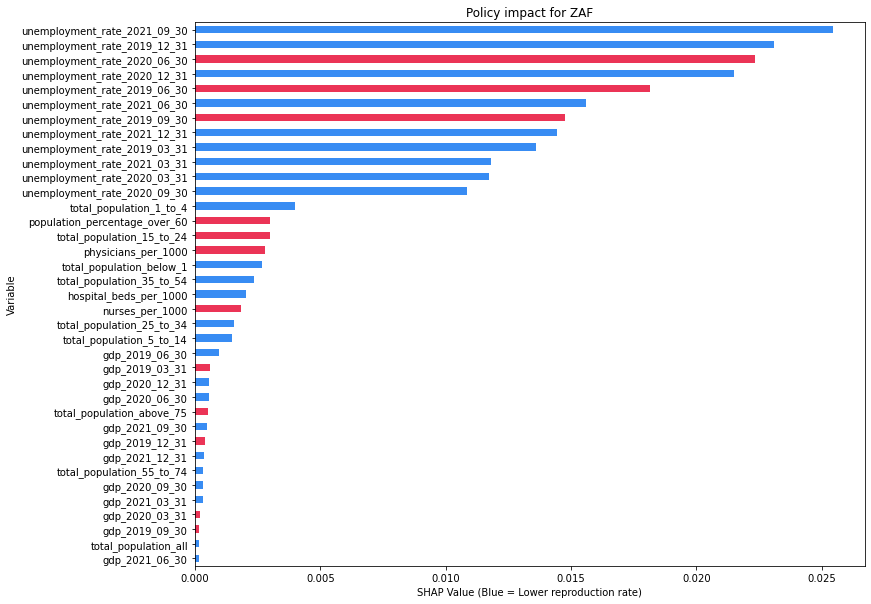

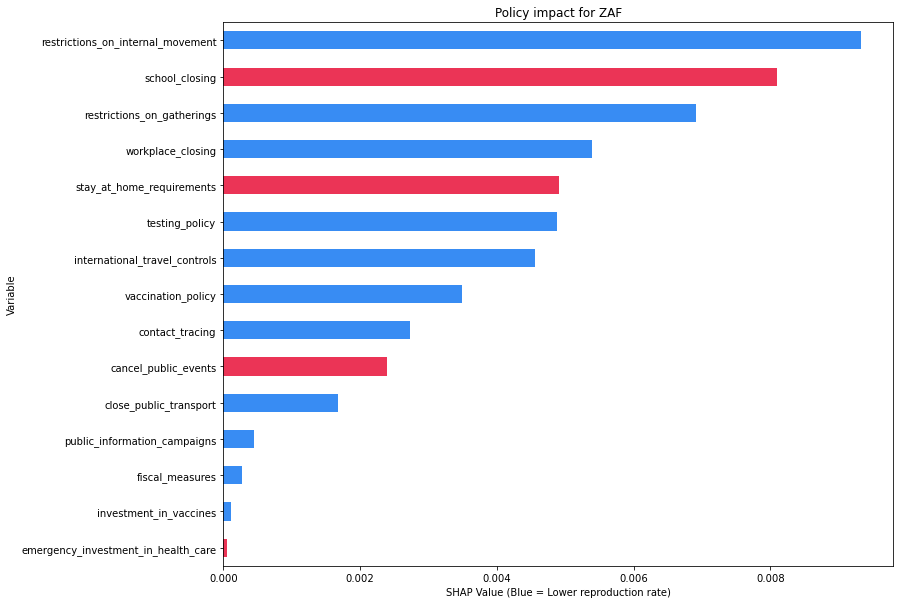

In [26]:
# Plotting shap
train, val = pipeline.get_data()

const_cols, var_cols = pipeline.get_cols()

plot.plot_shap(pipeline.get_model(), const_cols, var_cols, train, val, plot_bars=True, cols_to_drop = swissre_features['weather'])

- **ITA** - NEW MSE: 0.0206 OLD MSE: 0.0372 _New model is **better**_
- **USA** - NEW MSE: 0.0351 OLD MSE: 0.0171 _New model is **worse**_
- **AFG** - NEW MSE: 0.0234  OLD MSE: 0.1394 _New model is **better**_
- **CHE** - NEW MSE: 0.0273 OLD MSE: 0.0540 _New model is **better**_
- **ZAF** - NEW MSE: 0.0712 OLD MSE: 0.1597 _New model is **better**_
- **GBR** - NEW MSE: 0.0179 OLD MSE: 0.0458 _New model is **better**_
- **AUS** - NEW MSE: 0.0474 OLD MSE: 0.1517 _New model is **better**_
- **DEU** - NEW MSE: 0.0207 OLD MSE: 0.0318 _New model is **better**_
- **CHN** NEW MSE: 0.0997 OLD MSE: 0.1957 _New model is **better**_
- **BRA** NEW MSE: 0.0110 OLD MSE: 0.0260 _New model is **better**_
- **IND** NEW MSE: 0.0172 OLD MSE: 0.0091 _New model is **worse**_
- **SWE** NEW MSE: 0.0545 OLD MSE: 0.0456 _New model is **worse**_
- **RUS** NEW MSE: 0.0275 OLD MSE: 0.0409 _New model is **better**_

Average MSE - OLD: 0.0734
Average MSE - NEW: 0.0364

In [20]:
const_cols, var_cols = pipeline.get_cols()
var_cols

['FeelsLikeC',
 'HeatIndexC',
 'cancel_public_events',
 'close_public_transport',
 'contact_tracing',
 'emergency_investment_in_health_care',
 'fiscal_measures',
 'humidity',
 'international_travel_controls',
 'investment_in_vaccines',
 'maxtempC',
 'mintempC',
 'precipMM',
 'pressure',
 'public_information_campaigns',
 'restrictions_on_gatherings',
 'restrictions_on_internal_movement',
 'school_closing',
 'stay_at_home_requirements',
 'sunHour',
 'tempC',
 'testing_policy',
 'totalSnow_cm',
 'uvIndex',
 'vaccination_policy',
 'windspeedKmph',
 'workplace_closing']